# Band-edge filter construction

### References

fred harris, Multirate Signal Processing For Communications Systems, Section 13.4.2.

[fred harris, Elettra Venosa, Xiaofei Chen, Chris Dick, Band Edge Filters Perform Non Data-Aided Carrier and Timing Synchronization of Software Defined Radio QAM Receivers](https://s3.amazonaws.com/embeddedrelated/user/6420/wpmc_2012_be_synch_camera_ready_40098.pdf)

[fred harris, Band Edge Filters: Characteristics and Performance in Carrier and Symbol Synchronization](https://s3.amazonaws.com/embeddedrelated/user/124841/wpmc_2010_be_filters_5%20_21343.pdf)

In [1]:
%matplotlib inline
from gnuradio.filter import firdes
import matplotlib.pyplot as plt
import numpy as np
import pm_remez

plt.rcParams['figure.figsize'] = (7, 3.5)

## Desired filter frequency response

In [2]:
# design parameters

rolloff = 0.35  # RRC alpha
sps = 4  # samples per symbol

In [3]:
# other parameters
NFFT = 4096

In [4]:
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT))

The ideal frequency response of the band edge filter is the frequency derivative of the matched filter. For an RRC waveform, this gives a quarter-cosine spanning each frequency interval corresponding to the roll-off of the RRC filter.

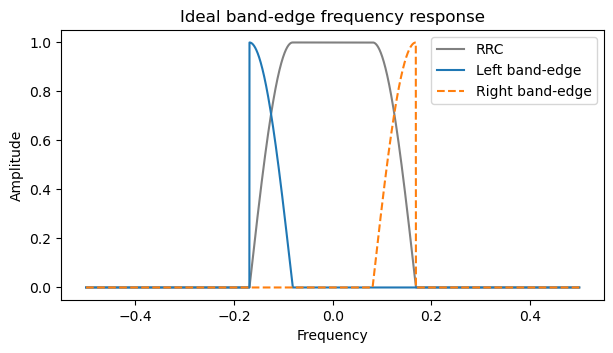

In [5]:
rrc_response = np.zeros(NFFT)
rrc_response[np.abs(faxis) <= 0.5 * (1 - rolloff) / sps] = 1
rrc_edge_sel = (0.5 * (1 - rolloff) / sps < np.abs(faxis)) & (np.abs(faxis) < 0.5 * (1 + rolloff) / sps)
rrc_edge = np.sqrt(0.5 * (1 + np.cos(np.pi * sps / rolloff * (np.abs(faxis) - 0.5 * (1 - rolloff) / sps))))
rrc_response[rrc_edge_sel] = rrc_edge[rrc_edge_sel]

left_band_edge = np.zeros(NFFT)
left_sel = (-0.5 * (1 + rolloff)/ sps < faxis) & (faxis < -0.5 * (1 - rolloff)/ sps)
left_n = np.sum(left_sel)
left_band_edge[(-0.5 * (1 + rolloff)/ sps < faxis) & (faxis < -0.5 * (1 - rolloff)/ sps)] = np.cos(np.pi/2 * np.arange(left_n) / left_n)
right_band_edge = left_band_edge[::-1]
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, left_band_edge, label='Left band-edge')
plt.plot(faxis, right_band_edge, '--', label='Right band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Ideal band-edge frequency response')
plt.legend();

## GNU Radio implementation

The GNU Radio filter design is implemented in `fll_band_edge_cc_impl::design_filter()` in https://github.com/gnuradio/gnuradio/blob/main/gr-digital/lib/fll_band_edge_cc_impl.cc. This section follows the same notation for the variable names.

The filter is designed as explained in the paper [Band Edge Filters: Characteristics and Performance in Carrier and Symbol Synchronization](https://s3.amazonaws.com/embeddedrelated/user/124841/wpmc_2010_be_filters_5%20_21343.pdf). The frequency response of the ideal band-edge is not realizable, because it is discontinuous. The filter is designed by extending the discontinuous quarter-cosine to a half-cosine, which is continuous and has a direct and simple time-domain expression as the sum of two offset sinc functions.

In [6]:
# design parameters
filter_size = 128

In [7]:
M = filter_size / sps
half_sps_inv = 2 / sps
i = np.arange(filter_size)
k = -M + i * half_sps_inv
position = rolloff * k
# note that sinc() in fll_band_edge_cc_impl.cc is defined in the same
# way as np.sinc(), this is sinc(x) = sin(pi * x) / (pi * x)
bb_taps = np.sinc(position - 0.5) + np.sinc(position + 0.5)
power = np.sum(bb_taps**2)

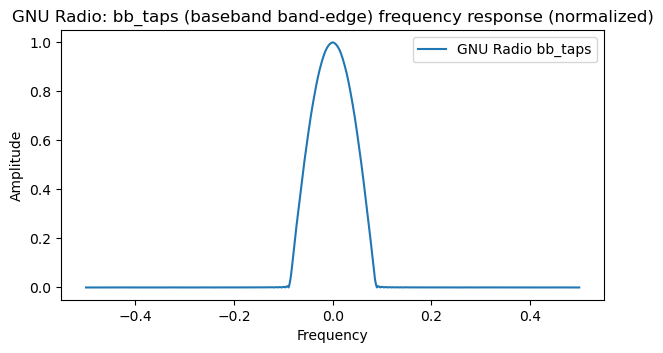

In [8]:
bb_taps_H = np.fft.fftshift(np.fft.fft(bb_taps, NFFT))
bb_taps_H /= np.max(np.abs(bb_taps_H))
plt.plot(faxis, np.abs(bb_taps_H), label='GNU Radio bb_taps')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('GNU Radio: bb_taps (baseband band-edge) frequency response (normalized)')
plt.legend();

In [9]:
N = (filter_size - 1) // 2
invpower = 1 / power
inv_twice_sps = 0.5 / sps
k = (i - N) * inv_twice_sps
taps_lower = bb_taps * invpower * np.exp(-1j * 2 * np.pi * (1 + rolloff) * k)
taps_upper = np.conj(taps_lower)

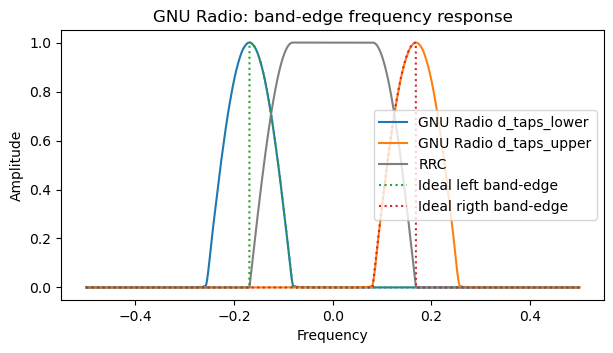

In [10]:
taps_lower_H = np.fft.fftshift(np.fft.fft(taps_lower, NFFT))
taps_upper_H = np.fft.fftshift(np.fft.fft(taps_upper, NFFT))
plt.plot(faxis, np.abs(taps_lower_H), label='GNU Radio d_taps_lower')
plt.plot(faxis, np.abs(taps_upper_H), label='GNU Radio d_taps_upper')
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, left_band_edge, ':', label='Ideal left band-edge')
plt.plot(faxis, right_band_edge, ':', label='Ideal rigth band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('GNU Radio: band-edge frequency response')
plt.legend();

## Filter design with pm-remez

The Remez algorithm can be used to obtain a more flexible band-edge filter design that trades off worse stopband rejection by a sharper transition bandwidth at the discontinuity of the ideal band-edge response.

The way to design a band-edge using Remez is to design an FIR with even symmetry and another FIR with odd symmetry, both approximating the desired frequency response for positive frequencies. Then the two complex band-edge filter can be obtained by adding and subtracting these two filters (the odd filter taps need to be multiplied by `1j`).

Here we design a 64-tap filter (which is around the minimum that is reasonable for 4 samples/symbol) as an example.

In [11]:
filter_size = 64

# GNU Radio design
M = filter_size / sps
half_sps_inv = 2 / sps
i = np.arange(filter_size)
k = -M + i * half_sps_inv
position = rolloff * k
bb_taps = np.sinc(position - 0.5) + np.sinc(position + 0.5)
N = (filter_size - 1) // 2
invpower = 1 / power
inv_twice_sps = 0.5 / sps
k = (i - N) * inv_twice_sps
taps_lower_gr = bb_taps * invpower * np.exp(-1j * 2 * np.pi * (1 + rolloff) * k)
taps_upper_gr = np.conj(taps_lower)
H_gr = np.fft.fftshift(np.fft.fft(taps_upper_gr, NFFT))

In [12]:
start = 0.5 * (1 - rolloff) / sps
end = 0.5 * (1 + rolloff) / sps
cutoff = 0.5 * (1 + (1 + 0.75) * rolloff) / sps
a = 2
design_cc, design_ss = (
    pm_remez.remez(filter_size,
                   [0, start, start, end, cutoff, 0.5],
                   [0, lambda f: np.cos(np.pi/2 * (f - end) / (rolloff/sps)), 0],
                   weight=[a, 1, a],
                   symmetry=symmetry)
    for symmetry in ['even', 'odd'])
remez_upper = 0.5 * np.array(design_cc.impulse_response) - 0.5j * np.array(design_ss.impulse_response)
remez_lower = 0.5 * np.array(design_cc.impulse_response) + 0.5j * np.array(design_ss.impulse_response)
H_remez = np.fft.fftshift(np.fft.fft(remez_upper, NFFT))

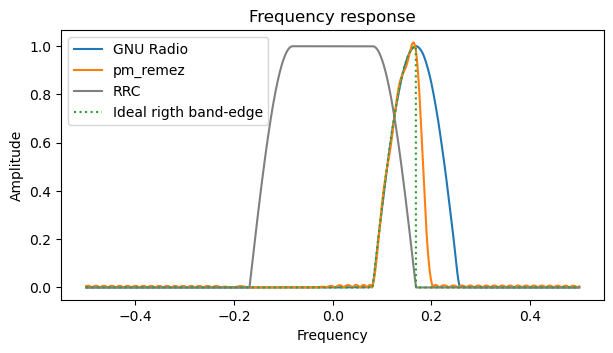

In [13]:
plt.plot(faxis, np.abs(H_gr), label='GNU Radio')
plt.plot(faxis, np.abs(H_remez), label='pm_remez')
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, right_band_edge, ':', label='Ideal rigth band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency response')
plt.legend();

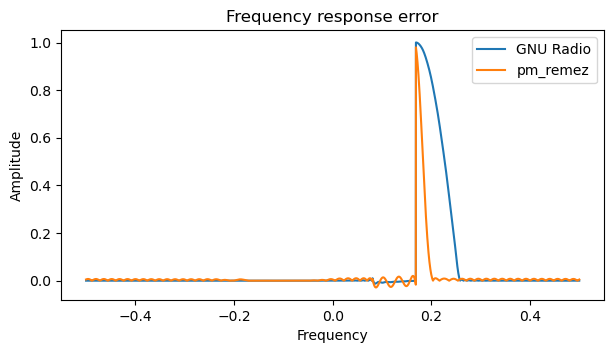

In [14]:
plt.plot(faxis, np.abs(H_gr) - right_band_edge, label='GNU Radio')
plt.plot(faxis, np.abs(H_remez) - right_band_edge, label='pm_remez')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency response error')
plt.legend();

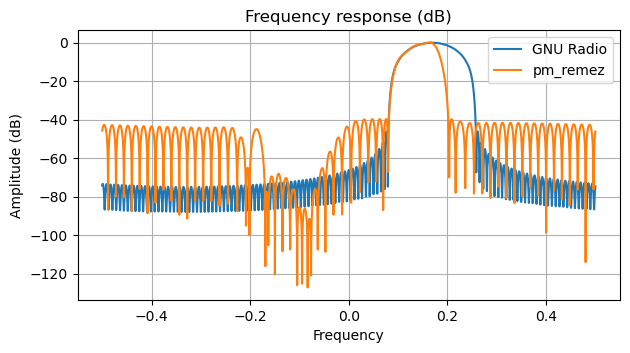

In [15]:
plt.plot(faxis, 20*np.log10(np.abs(H_gr)), label='GNU Radio')
plt.plot(faxis, 20*np.log10(np.abs(H_remez)), label='pm_remez')
plt.xlabel('Frequency')
plt.ylabel('Amplitude (dB)')
plt.title('Frequency response (dB)')
plt.legend()
plt.grid();

## Discriminant gain

This section performs a simulation to show that the gain of the frequency error discriminant, which is the difference in powers of the upper and lower band-edge filters, is equal to `sps` when the input waveform is normalized to power one (the expected value of the magnitude squared of each input sample is one) and frequency is expressed in units of cycles/sample.

First use GNU Radio `firdes` to design an RRC pulse-shape filter to create a simulated RRC waveform.

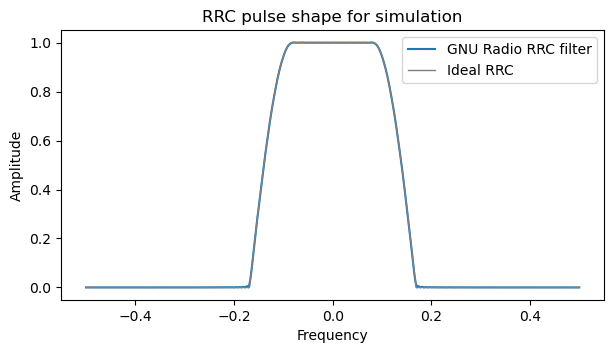

In [16]:
rrc_pulse = firdes.root_raised_cosine(sps, sps, 1, rolloff, 32 * sps)
rrc_pulse_H = np.fft.fftshift(np.fft.fft(rrc_pulse, NFFT)) / sps
plt.plot(faxis, np.abs(rrc_pulse_H), label='GNU Radio RRC filter')
plt.plot(faxis, rrc_response, linewidth=1, color='grey', label='Ideal RRC')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('RRC pulse shape for simulation')
plt.legend();

Create a simulated RRC waveform at complex baseband by interpolating symbols with the RRC pulse-shape filter. Symbols are chosen to be Gaussian, but this doesn't matter. They could be drawn randomly from any constellation.

In [17]:
N_samp = sps * 2**16
random_symbols = np.zeros(N_samp, 'complex')
random_symbols[::sps] = (np.random.randn(N_samp // sps) + 1j * np.random.randn(N_samp // sps)) / np.sqrt(2)
rrc_waveform = np.convolve(rrc_pulse, random_symbols, mode='valid')

Check that the simulated RRC waveform is normalized to power one.

In [18]:
rrc_waveform_power = np.average(np.abs(rrc_waveform)**2)
assert np.abs(rrc_waveform_power - 1) < 1e-2
rrc_waveform_power

np.float64(1.0014977703188572)

Compute the discriminant at equally spaced frequencies between `-rolloff/sps` and `rolloff/sps`. Note that, by construction, the discriminant saturates when the frequency error is larger than `rolloff/sps`.

In [19]:
def discriminant_gr(freq):
    rrc_waveform_freq = np.exp(2 * np.pi * 1j * freq * np.arange(rrc_waveform.size)) * rrc_waveform
    return np.average(np.abs(np.convolve(taps_upper, rrc_waveform_freq, mode='valid'))**2
                      - np.abs(np.convolve(taps_lower, rrc_waveform_freq, mode='valid'))**2)

def discriminant_remez(freq):
    rrc_waveform_freq = np.exp(2 * np.pi * 1j * freq * np.arange(rrc_waveform.size)) * rrc_waveform
    return np.average(np.abs(np.convolve(remez_upper, rrc_waveform_freq, mode='valid'))**2
                      - np.abs(np.convolve(remez_lower, rrc_waveform_freq, mode='valid'))**2)

freqs = np.linspace(-rolloff/sps, rolloff/sps, 100, endpoint=True)
discriminants_gr = np.array([discriminant_gr(f) for f in freqs])
discriminants_remez = np.array([discriminant_remez(f) for f in freqs])

Note that the pm_remez discriminant saturates earlier. The reason is that due to the narrower transition bandwidth, the RRC rolloff is shifted completely past the end of the band-edge filter passband at a lower frequency error.

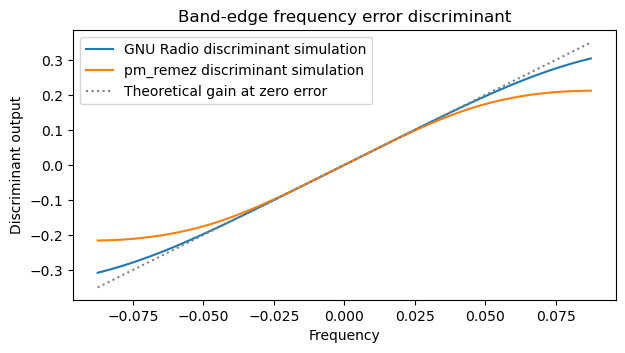

In [20]:
discr_gain = sps
plt.plot(freqs, discriminants_gr, label='GNU Radio discriminant simulation')
plt.plot(freqs, discriminants_remez, label='pm_remez discriminant simulation')
plt.plot(freqs, discr_gain * freqs, ':', color='grey', label='Theoretical gain at zero error')
plt.title('Band-edge frequency error discriminant')
plt.xlabel('Frequency')
plt.ylabel('Discriminant output')
plt.legend();